In [1]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from html import unescape
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer as porterStemmer
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

In [22]:
data_obama_o = pd.read_excel('Romney_tweets.xlsx', header=1)

In [23]:
data_obama_o = data_obama_o.drop(['date', 'time'], axis=1)
data_obama_o.head()

,Anootated tweet,Class
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
1,Senior <e>Romney</e> Advisor Claims <e>Obama</...,2
2,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
3,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
4,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1


In [24]:
#Drop Class 2
data_obama_o['Class'] = data_obama_o['Class'].apply(str)
# print(data_obama[data_obama['Class']=='irrevelant'].count())
# print(data_obama[data_obama['Class']=='irrelevant'].count())
# print(data_obama[data_obama['Class']=='2'].count())
# print(data_obama[data_obama['Class']=='1'].count())
# print(data_obama[data_obama['Class']=='0'].count())
# print(data_obama[data_obama['Class']=='-1'].count())

data_obama_o = data_obama_o[(data_obama_o['Class'] == '1') | (data_obama_o['Class'] == '0') | (data_obama_o['Class'] == '-1')]

In [25]:
#Drop empty rows
print("After dropping Class 2: ", data_obama_o.count())
data_obama_o['Class'] = data_obama_o['Class'].apply(int)
data_obama_o = data_obama_o.dropna()
print("After dropping empty rows: ", data_obama_o.count())

After dropping Class 2:  Anootated tweet    5648
Class              5648
dtype: int64
After dropping empty rows:  Anootated tweet    5648
Class              5648
dtype: int64


In [26]:
data_obama = data_obama_o.copy()

In [27]:
data_obama['pre_clean_len'] = [len(t) for t in data_obama['Anootated tweet']]

In [28]:
print(data_obama['Class'].dtype)

int64


In [29]:
data_dict = {
    'sentiment':{
        'type':data_obama['Class'].dtype,
        'description':'label class - -1:negative, 1:positive, 0:neutral'
    },
    'text':{
        'type':data_obama['Anootated tweet'].dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':data_obama['pre_clean_len'].dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':data_obama.shape
}
pprint(data_dict)

{'dataset_shape': (5648, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'label class - -1:negative, 1:positive, '
                              '0:neutral',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


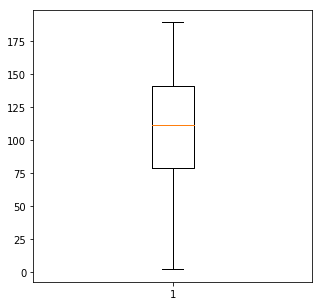

In [30]:
#Ensure that all tweets are within limits of 140 characters
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data_obama.pre_clean_len)
plt.show()

In [31]:
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [32]:
def removeStopWords(tweet):
    
    filtered_tweet = [];

    #stemming
    porter = porterStemmer()
    stemmedTweet = [porter.stem(word) for word in tweet.split(" ")]
    stemmedTweet = " ".join(stemmedTweet)
    tweet = str(stemmedTweet);
    
    tweet = tweet.replace("'", "");
    
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(['RT'])
    
    word_tokens = word_tokenize(tweet)
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_tweet.append(w)
    
    eachTweet = " ".join(filtered_tweet)  
    
    return eachTweet

In [33]:
def lemmatization(tweet):
    
    tweet_list = tweet.split()
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
        
    eachTweet = " ".join(normalized_tweet) 
    
    return eachTweet

In [34]:
def preprocess_tweet(row):
    
    text = row['Anootated tweet']
    
    # HTML Decoding
    soup = BeautifulSoup(unescape(text), 'lxml')
    text = soup.text
    
    # Removing @
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    
    # Remove URL links
    text = re.sub('https?://[A-Za-z0-9./]+','',text)
    text = re.sub(r'www.[^ ]+', '', text)
    
    # Lower Case
    text = text.lower()
    
    #Remove words with repetition greater than 2
    word = re.sub(r'(.)\1+', r'\1\1', text)
    
    text = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
    
    # Remove Hashtags & Numbers
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # remove extra white spaces
    text = re.sub(r'\s+', r' ', text)
    
    text = removeStopWords(text)
    
    text = lemmatization(text)
    
    return text

In [35]:
data_obama['Anootated tweet'] = data_obama.apply(preprocess_tweet, axis=1)

In [17]:
data_obama.head()

,Anootated tweet,Class,pre_clean_len
0,kirkpatrick wear basebal cap embroid barack ob...,0,136
2,obama debat cracker ass cracker tonight tune t...,1,88
4,miss point im afraid understand bigger pictur ...,0,140
6,wa rais democrat leave parti year ago lifetim ...,-1,146
7,obama camp afford lower expect tonight debat p...,0,124


In [18]:
#For word cloud

#For negative
neg_tweets = data_obama[data_obama['Class'] == -1]
neg_string = []
for t in neg_tweets['Anootated tweet']:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

#For positive
pos_tweets = data_obama[data_obama['Class'] == 1]
pos_string = []
for t in pos_tweets['Anootated tweet']:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

#For neutral
neut_tweets = data_obama[data_obama['Class'] == 0]
neut_string = []
for t in neut_tweets['Anootated tweet']:
    neut_string.append(t)
neut_string = pd.Series(neut_string).str.cat(sep=' ')

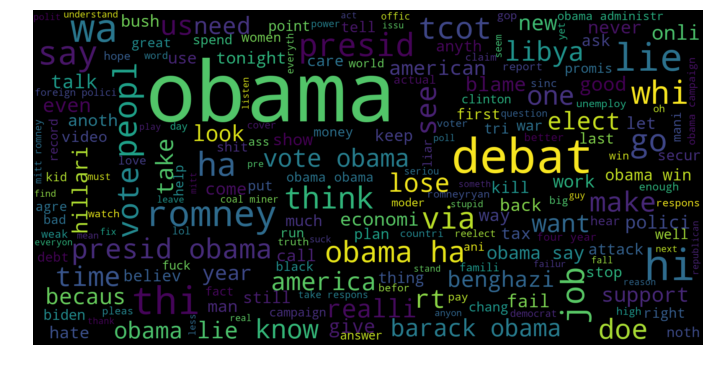

In [19]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

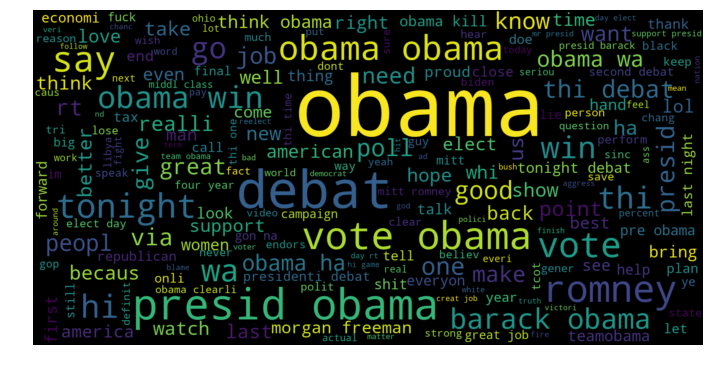

In [20]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

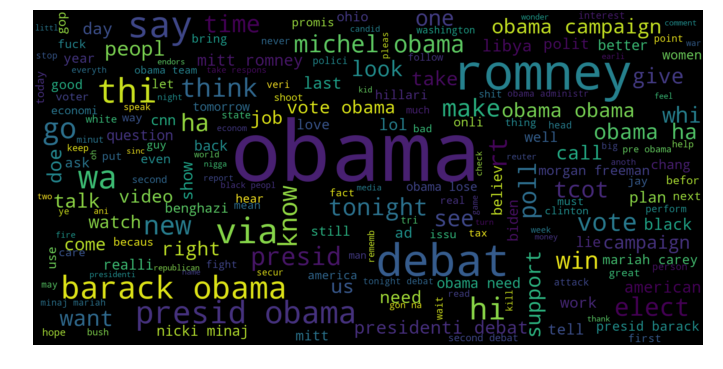

In [21]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neut_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [68]:
# Count Vectoriser
cvec = CountVectorizer()
cvec.fit(data_obama['Anootated tweet'])

CountVectorizer()

In [69]:
len(cvec.get_feature_names())

8136

In [70]:
document_matrix = cvec.transform(data_obama['Anootated tweet'])
data_obama[data_obama['Class'] == 0].tail()

,Anootated tweet,Class,pre_clean_len
7168,read of the political environment during assas...,0,143
7188,romneyaides take aim at cnn crowley after tues...,0,87
7189,y all are talking about romney s a liar all po...,0,113
7191,challenge million democrats step up only each...,0,132
7196,el por ciento de las mujeres blancas casadas r...,0,76


In [71]:
neg_doc_matrix = cvec.transform(data_obama[data_obama['Class'] == -1]['Anootated tweet'])
pos_doc_matrix = cvec.transform(data_obama[data_obama['Class'] == 1]['Anootated tweet'])
neut_doc_matrix = cvec.transform(data_obama[data_obama['Class'] == 0]['Anootated tweet'])

neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neut_tf = np.sum(neut_doc_matrix,axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neut = np.squeeze(np.asarray(neut_tf))

term_freq_df = pd.DataFrame([neg,pos,neut],columns=cvec.get_feature_names()).transpose()

In [72]:
term_freq_df

,0,1,2
aaadriaaan,1,0,0
aaron,1,0,0
ab,1,0,0
abandoning,0,1,0
abc,1,1,7
...,...,...,...
zogby,0,3,0
zorn,0,0,1
zugt,0,1,0
zumba,0,0,1


In [73]:
term_freq_df.columns = ['negative', 'positive', 'neutral']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive'] + term_freq_df['neutral']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,neutral,total
romney,2823,1064,1609,5496
the,1264,406,695,2365
to,993,277,519,1789
mitt,730,226,394,1350
is,784,225,301,1310
not,719,155,288,1162
for,553,252,280,1085
of,558,146,290,994
in,428,229,309,966
he,610,131,208,949


Text(0.5,1,'Top 500 tokens in tweets')

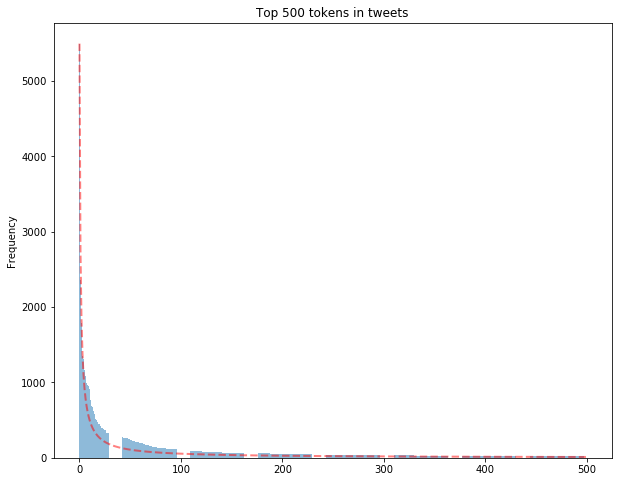

In [74]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

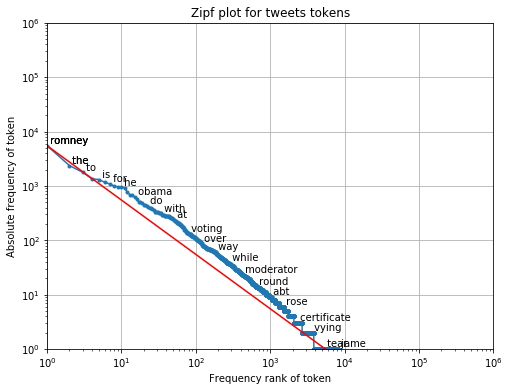

In [75]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Text(0.5,1,'Top 50 tokens in negative tweets')

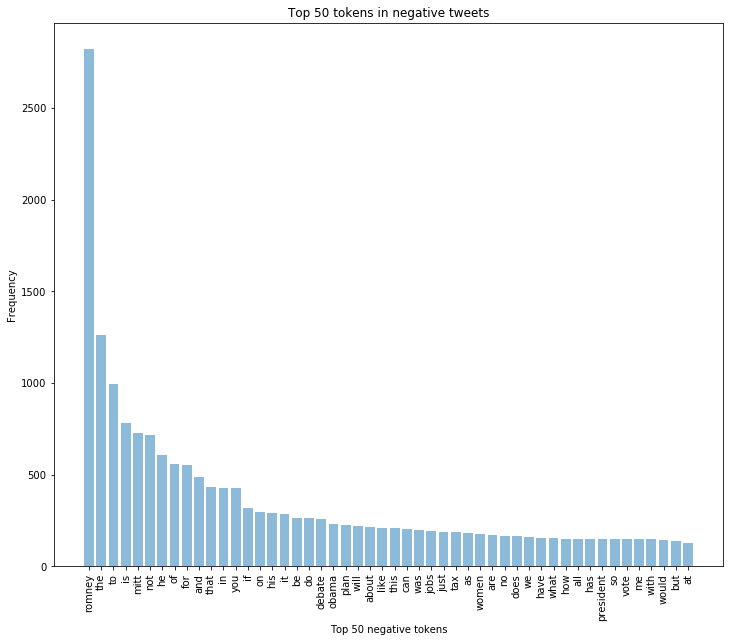

In [76]:
#Top 50 negative words
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,'Top 50 tokens in positive tweets')

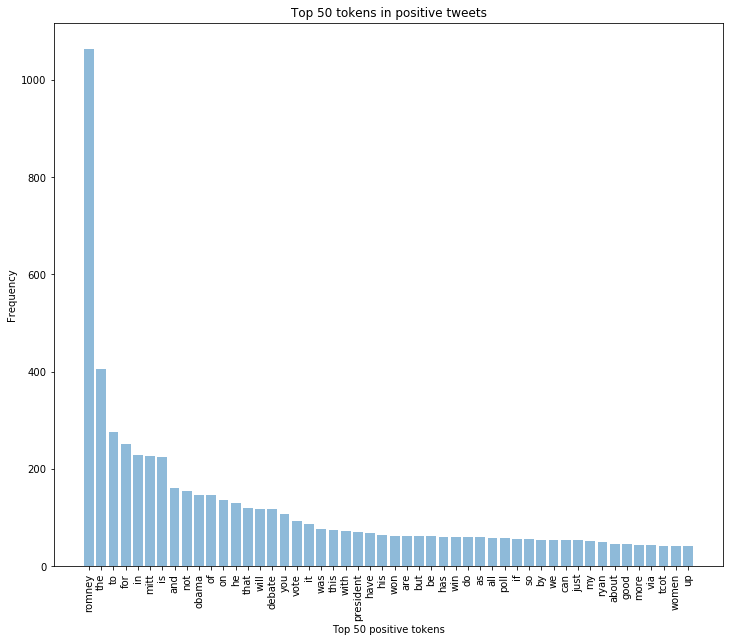

In [77]:
#Top 50 positive words
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5,1,'Top 50 tokens in neutral tweets')

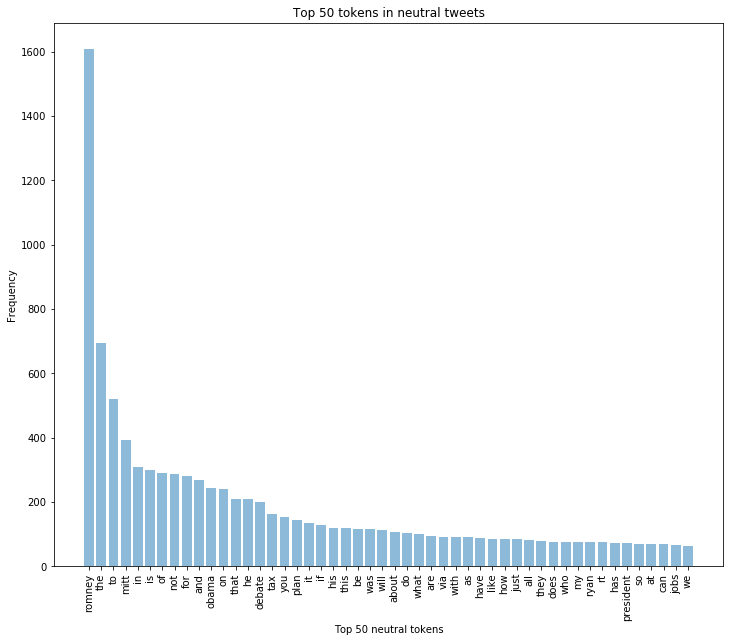

In [78]:
#Top 50 neutral words
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 neutral tokens')
plt.title('Top 50 tokens in neutral tweets')

In [79]:
#Ranking words

term_freq_df['pos_rate'] = term_freq_df['positive'] * 1./term_freq_df['total']
#term_freq_df.sort_values(by='pos_rate', ascending=False).iloc[:10]


In [80]:
term_freq_df['neg_rate'] = term_freq_df['negative'] * 1./term_freq_df['total']
#term_freq_df.sort_values(by='neg_rate', ascending=False).iloc[:10]

In [81]:
term_freq_df['neut_rate'] = term_freq_df['neutral'] * 1./term_freq_df['total']
#term_freq_df.sort_values(by='neut_rate', ascending=False).iloc[:10]

In [82]:
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] * 1./term_freq_df['positive'].sum()
# term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

term_freq_df['neg_freq_pct'] = term_freq_df['negative'] * 1./term_freq_df['negative'].sum()
# term_freq_df.sort_values(by='neg_freq_pct', ascending=False).iloc[:10]

term_freq_df['neut_freq_pct'] = term_freq_df['neutral'] * 1./term_freq_df['neutral'].sum()
# term_freq_df.sort_values(by='neut_freq_pct', ascending=False).iloc[:10]

In [83]:
from scipy.stats import hmean
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) 
                                                            if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']]) 
                                                            if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df['neut_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neut_rate'], x['neut_freq_pct']]) 
                                                            if x['neut_rate'] > 0 and x['neut_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,neutral,total,pos_rate,neg_rate,neut_rate,pos_freq_pct,neg_freq_pct,neut_freq_pct,pos_hmean,neg_hmean,neut_hmean
romney,2823,1064,1609,5496,0.193595,0.513646,0.292758,0.076125,0.066805,0.072559,0.109280,0.118233,0.116295
the,1264,406,695,2365,0.171670,0.534461,0.293869,0.029048,0.029912,0.031342,0.049688,0.056654,0.056642
to,993,277,519,1789,0.154835,0.555059,0.290106,0.019818,0.023499,0.023405,0.035139,0.045089,0.043315
for,553,252,280,1085,0.232258,0.509677,0.258065,0.018030,0.013087,0.012627,0.033462,0.025518,0.024076
in,428,229,309,966,0.237060,0.443064,0.319876,0.016384,0.010128,0.013935,0.030650,0.019804,0.026706
mitt,730,226,394,1350,0.167407,0.540741,0.291852,0.016169,0.017275,0.017768,0.029490,0.033481,0.033496
is,784,225,301,1310,0.171756,0.598473,0.229771,0.016098,0.018553,0.013574,0.029437,0.035991,0.025633
and,486,162,268,916,0.176856,0.530568,0.292576,0.011590,0.011501,0.012086,0.021755,0.022514,0.023213
not,719,155,288,1162,0.133391,0.618761,0.247849,0.011090,0.017015,0.012988,0.020477,0.033119,0.024682
obama,233,146,243,622,0.234727,0.374598,0.390675,0.010446,0.005514,0.010958,0.020001,0.010868,0.021319


In [84]:
print(data_obama[data_obama['Class']==0].count())

Anootated tweet    1680
Class              1680
pre_clean_len      1680
dtype: int64


In [85]:
x = data_obama['Anootated tweet']
y = data_obama['Class']
SEED = 2000

# Split data
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.1, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [86]:
# Random accuracy
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

tbresult = [TextBlob(i).sentiment.polarity for i in x_test]

In [87]:
tbpred = []
for n in tbresult:
    if n<0:
        tbpred.append(-1)
    elif n>0:
        tbpred.append(1)
    else:
        tbpred.append(0)
        
        
conmat = np.array(confusion_matrix(y_test, tbpred, labels=[1,0,-1]))
confusion = pd.DataFrame(conmat, index=['positive', 'neutral','negative'],
                         columns=['predicted_positive','predicted_neutral', 'predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_test, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_test, tbpred))

Accuracy Score: 42.76%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_neutral  predicted_negative
positive                  30                 25                   6
neutral                   38                 51                  12
negative                  31                 50                  40
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

          -1       0.69      0.33      0.45       121
           0       0.40      0.50      0.45       101
           1       0.30      0.49      0.37        61

    accuracy                           0.43       283
   macro avg       0.47      0.44      0.42       283
weighted avg       0.50      0.43      0.43       283



In [88]:
def removeStopWords(tweet):
    
    filtered_tweet = [];

    #stemming
    porter = porterStemmer()
    stemmedTweet = [porter.stem(word) for word in tweet.split(" ")]
    stemmedTweet = " ".join(stemmedTweet)
    tweet = str(stemmedTweet);
    
    tweet = tweet.replace("'", "");
    
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(['RT'])
    
    word_tokens = word_tokenize(tweet)
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_tweet.append(w)
    
    eachTweet = " ".join(filtered_tweet)  
    
    return eachTweet

In [89]:
def secondaryPreProcess(row):
    
    text = row['Anootated Tweets']
    
    #Remove emojis
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    

In [90]:
from nltk.corpus import stopwords
cvec = CountVectorizer()
n_features = np.arange(10000,100001,10000)
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(['rt'])
ngram_range = (1,2)
for n in n_features:
        cvec.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)

In [91]:
train_vectors = cvec.fit(x_train);

In [92]:
print(train_vectors)

CountVectorizer(max_features=100000, ngram_range=(1, 2),
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})


In [93]:
from time import time

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


In [94]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 64.31%
accuracy score: 58.30%
model is 6.01% less accurate than null accuracy
train and test time: 6.72s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 64.31%
accuracy score: 62.54%
model is 1.77% less accurate than null accuracy
train and test time: 1.89s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
null accuracy: 64.31%
accuracy score: 63.25%
model is 1.06% less accurate than null accuracy
train and test time: 2.00s
--------------------------------------------------------------------------------
Va

In [95]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print (checker_pipeline)
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 3))),
                ('classifier', LogisticRegression())])
Validation result for Logistic Regression
LogisticRegression()
null accuracy: 64.31%
accuracy score: 58.30%
model is 6.01% less accurate than null accuracy
train and test time: 5.18s
--------------------------------------------------------------------------------
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 3))),
                ('classifier', LinearSVC())])
Validation result for Linear SVC
LinearSVC()
null accuracy: 64.31%
accuracy score: 62.54%
model is 1.77% less accurate than null accuracy
train and test time: 0.75s
--------------------------------------------------------------------------------
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 3))),
                ('classifier', MultinomialNB())])
Validation result 